# Análise Preditiva Avançada


# Preparação dos dados para análise

## Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import warnings
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import probplot, norm

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from scipy.stats import zscore

from sklearn.model_selection import train_test_split

from sklearn.externals import joblib

warnings.filterwarnings('ignore')

pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.svm import SVR

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

## Carregamento do dataset

In [67]:
df = pd.read_csv('https://raw.githubusercontent.com/lsnascimento/apa/master/input/Retail.csv', parse_dates=['Date'], na_values=['#N/D'])
df_copy = df.copy()

In [68]:
seed = 314

## Métodos

In [5]:
def count_null(data):
    count = data.isnull().sum()
    perc = data.isnull().sum() / df.shape[0] * 100
    
    df_nulls = pd.DataFrame({
        'Count': count,
        'Percentage': round(perc, 2)
    })
    
    return df_nulls[df_nulls['Count'] > 0].sort_values(by='Count', ascending=False)

In [6]:
def remove_outlier(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    return data[
        ~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)
    ]

In [78]:
def plot_num(title, data, tipo='dist'):
    nrow = 2
    ncol = 3

    current_row = 0
    current_col = 0

    fig, axs = plt.subplots(nrow, ncol, figsize=(16, 10))

    fig.suptitle(title, y=1.05, fontsize=18)

    for k, v in enumerate(data.columns): 
        if k == ncol:
            current_row += 1
            current_col = 0

        if tipo == 'dist':
            sns.distplot(data[v], ax=axs[current_row, current_col])
        else:
            sns.boxplot(orient='v', data=data[v], ax=axs[current_row, current_col])
            
        axs[current_row, current_col].set_xlabel(v)

        current_col += 1

    plt.tight_layout()

    plt.show()

In [8]:
def model_accuracy(model, data, target):
    cv_results = cross_val_predict(model, data, target, cv=10)

    RMSE = np.sqrt(mean_squared_error(target, cv_results))
    MAE = mean_absolute_error(target, cv_results)
    R2 = r2_score(target, cv_results)
    
    return {
        'RMSE': RMSE,
        'MAE': MAE,
        'R2': R2
    }

In [9]:
def plot_metrics(data, metric=None):
    data_plot = dict()

    for modelo, resultado in data:
        data_plot[modelo] = resultado
        
    df_plot = pd.DataFrame(data_plot)
        
    if metric is None:
        df_plot_ordered = df_plot.sort_values(by=metric, ascending=False)
    elif metric not in df_plot.index:
        raise ValueError('Métrica {!r} não encontrada'.format(metric))
    else:
        df_plot_ordered = df_plot.loc[metric].to_frame().sort_values(by=metric)
    
    '''
    PLOT
    '''
    width = 0.8
    
    x_bar = np.arange(df_plot_ordered.shape[0])
    y_bar = df_plot_ordered.values.reshape(-1)
    cols = df_plot_ordered.index
    
    _, ax = plt.subplots(figsize=(12, 6))
    
    print(df_plot_ordered)
    
    p1 = ax.bar(
        x_bar, 
        y_bar, 
        width
    )
    
    ax.set_xlabel('Models')
    ax.set_xticks(x_bar)
    ax.set_xticklabels(cols)
    
    ax.set_ylabel('Scores')
    
    for rect in p1:
        height = rect.get_height()
        
        ax.annotate(
            '{:.3f}'.format(height),
            xy=(rect.get_x() + rect.get_width() / 2.4, height),
            xytext=(0, 3),
            textcoords='offset points'
        )
        
    plt.title('Avaliação da métrica %s' % metric, fontsize=18)
    
    plt.show()

# Análise Exploratória dos Dados

## Conhecimento do dataset

In [8]:
df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales
0,1,2010-05-02,42.31,2.57,nan,nan,nan,nan,nan,211.10,8.11,False,1643690.90
1,1,2010-12-02,38.51,2.55,nan,nan,nan,nan,nan,211.24,8.11,True,1641957.44
2,1,2010-02-19,39.93,2.51,nan,nan,nan,nan,nan,211.29,8.11,False,1611968.17
3,1,2010-02-26,46.63,2.56,nan,nan,nan,nan,nan,211.32,8.11,False,1409727.59
4,1,2010-05-03,46.50,2.62,nan,nan,nan,nan,nan,211.35,8.11,False,1554806.68


In [9]:
df.shape

(8190, 13)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 13 columns):
Store           8190 non-null int64
Date            8190 non-null datetime64[ns]
Temperature     8190 non-null float64
Fuel_Price      8190 non-null float64
MarkDown1       4032 non-null float64
MarkDown2       2921 non-null float64
MarkDown3       3613 non-null float64
MarkDown4       3464 non-null float64
MarkDown5       4050 non-null float64
CPI             7605 non-null float64
Unemployment    7605 non-null float64
IsHoliday       8190 non-null bool
Weekly_Sales    6435 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(10), int64(1)
memory usage: 775.9 KB


## Estatística descritiva

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,8190.00,23.00,12.99,1.00,12.00,23.00,34.00,45.00
Temperature,8190.00,59.36,18.68,-7.29,45.90,60.71,73.88,101.95
Fuel_Price,8190.00,3.41,0.43,2.47,3.04,3.51,3.74,4.47
MarkDown1,4032.00,7032.37,9262.75,-2781.45,1577.53,4743.58,8923.31,103184.98
MarkDown2,2921.00,3384.18,8793.58,-265.76,68.88,364.57,2153.35,104519.54
MarkDown3,3613.00,1760.10,11276.46,-179.26,6.60,36.26,163.15,149483.31
MarkDown4,3464.00,3292.94,6792.33,0.22,304.69,1176.42,3310.01,67474.85
MarkDown5,4050.00,4132.22,13086.69,-185.17,1440.83,2727.14,4832.56,771448.10
CPI,7605.00,172.46,39.74,126.06,132.36,182.76,213.93,228.98
Unemployment,7605.00,7.83,1.88,3.68,6.63,7.81,8.57,14.31


Analisando o index "count" observa-se que existem alguns valores faltantes em determinadas variáveis. Logo mais será analisado a quantidade e o percentual de cada uma delas.

In [12]:
df.skew()

Store           0.00
Temperature    -0.28
Fuel_Price     -0.31
MarkDown1       4.02
MarkDown2       4.96
MarkDown3       8.13
MarkDown4       4.86
MarkDown5      50.28
CPI             0.07
Unemployment    1.07
IsHoliday       3.33
Weekly_Sales    0.67
dtype: float64

In [13]:
df.kurtosis()

Store            -1.20
Temperature      -0.61
Fuel_Price       -0.95
MarkDown1        23.69
MarkDown2        32.34
MarkDown3        72.07
MarkDown4        29.00
MarkDown5      2923.06
CPI              -1.83
Unemployment      2.50
IsHoliday         9.08
Weekly_Sales      0.05
dtype: float64

## Seleção das variáveis numéricas

In [69]:
feat_num = df.select_dtypes(include=np.float64)
feat_cat = df.select_dtypes(include=np.object)

In [70]:
feat_num.columns

Index(['Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Weekly_Sales'],
      dtype='object')

In [12]:
feat_cat.columns

Index([], dtype='object')

## Valores Faltantes

In [60]:
df_missing = count_null(feat_num)
df_missing

,Count,Percentage
MarkDown2,5269,64.33
MarkDown4,4726,57.70
MarkDown3,4577,55.89
MarkDown1,4158,50.77
MarkDown5,4140,50.55
Weekly_Sales,1755,21.43
CPI,585,7.14
Unemployment,585,7.14


Observa-se que a maioria das variáveis possuem mais de 50% dos seus dados faltantes.

In [92]:
#df.dropna(inplace=True, axis=0)
#df.reset_index(inplace=True, drop=True)

# df.drop(['leval_0', 'index'], axis=1)

In [14]:
for idx in df_missing.index:
    if df_missing.loc[idx, 'Percentage'] > 50:
        df.drop(idx, axis=1, inplace=True)
        continue
        
    df[idx].fillna(df[idx].mean(), inplace=True)

Neste primeiro teste será removido as features com um percentual maior ou igual à 50% de valores faltantes.

## Outliers

In [99]:
df.drop(['index'], axis=1, inplace=True)
df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales
0,1,2011-11-11,59.11,3.30,10382.90,6115.67,215.07,2406.62,6551.42,218.00,7.87,False,1594938.89
1,1,2011-11-18,62.25,3.31,6074.12,254.39,51.98,427.39,5988.57,218.22,7.87,False,1539483.70
2,1,2011-11-25,60.14,3.24,410.31,98.00,55805.51,8.00,554.92,218.47,7.87,True,2033320.66
3,1,2011-02-12,48.91,3.17,5629.51,68.00,1398.11,2084.64,20475.32,218.71,7.87,False,1584083.95
4,1,2011-09-12,43.93,3.16,4640.65,19.00,105.02,3639.42,14461.82,218.96,7.87,False,1799682.38


In [101]:
df_num = df.select_dtypes(include=np.float64)

IndexError: index 3 is out of bounds for axis 1 with size 3

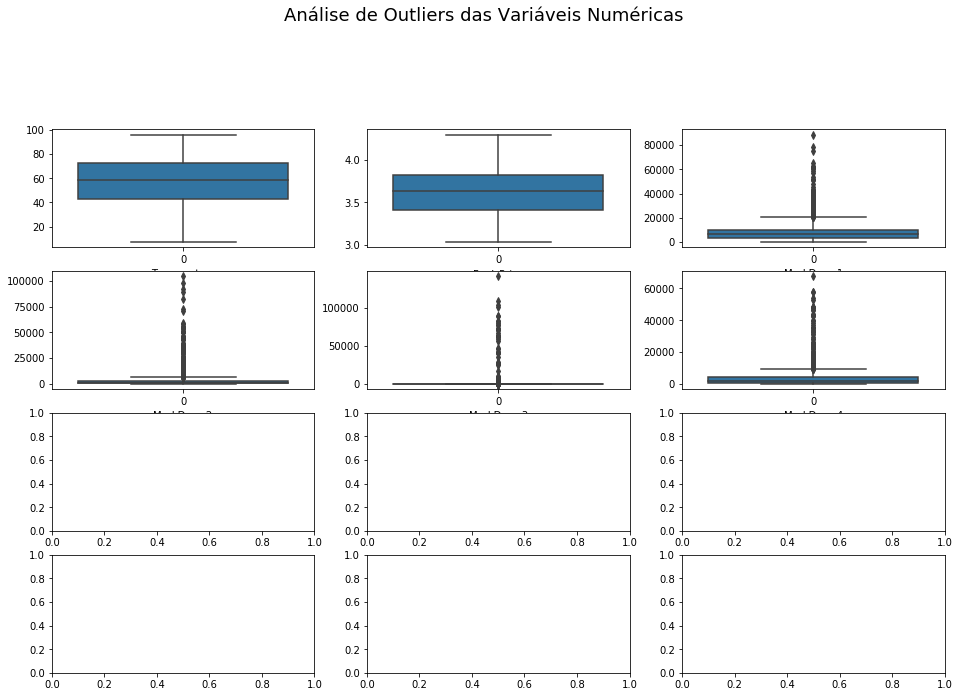

In [102]:
plot_num('Análise de Outliers das Variáveis Numéricas', df_num, 'boxplot')

Análise...

In [103]:
# Removendo outliers

df_outliers = remove_outlier(df_num)
df = df.iloc[df_outliers.index, :]

df_outliers.shape, df_num.shape

((833, 10), (1395, 10))

KeyError: 0

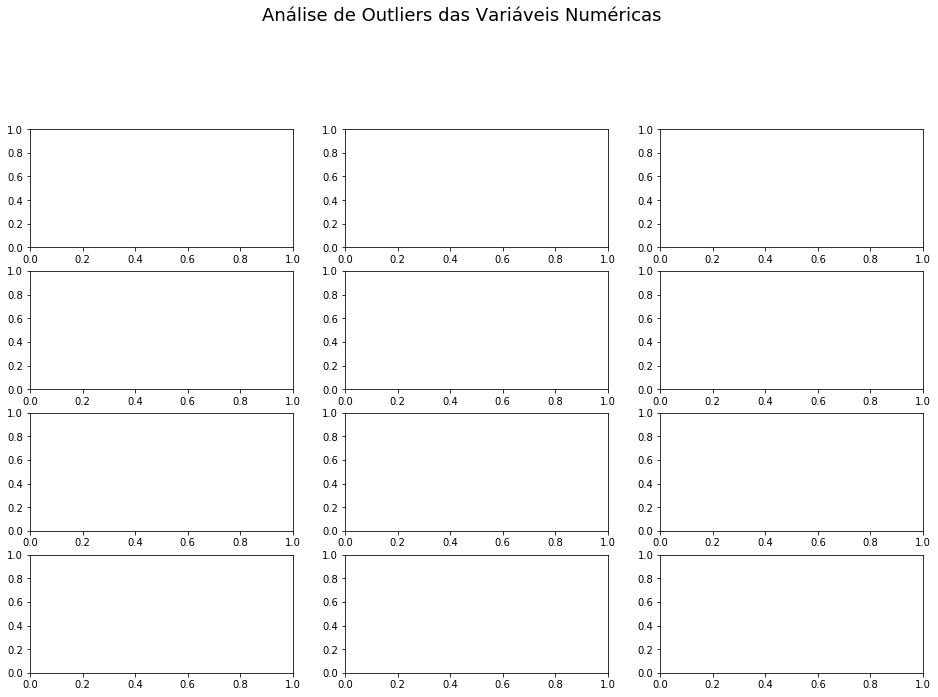

In [104]:
plot_num('Análise de Outliers das Variáveis Numéricas', df_outliers, 'boxplot')

Análise...

## Distribuição das variáveis numéricas

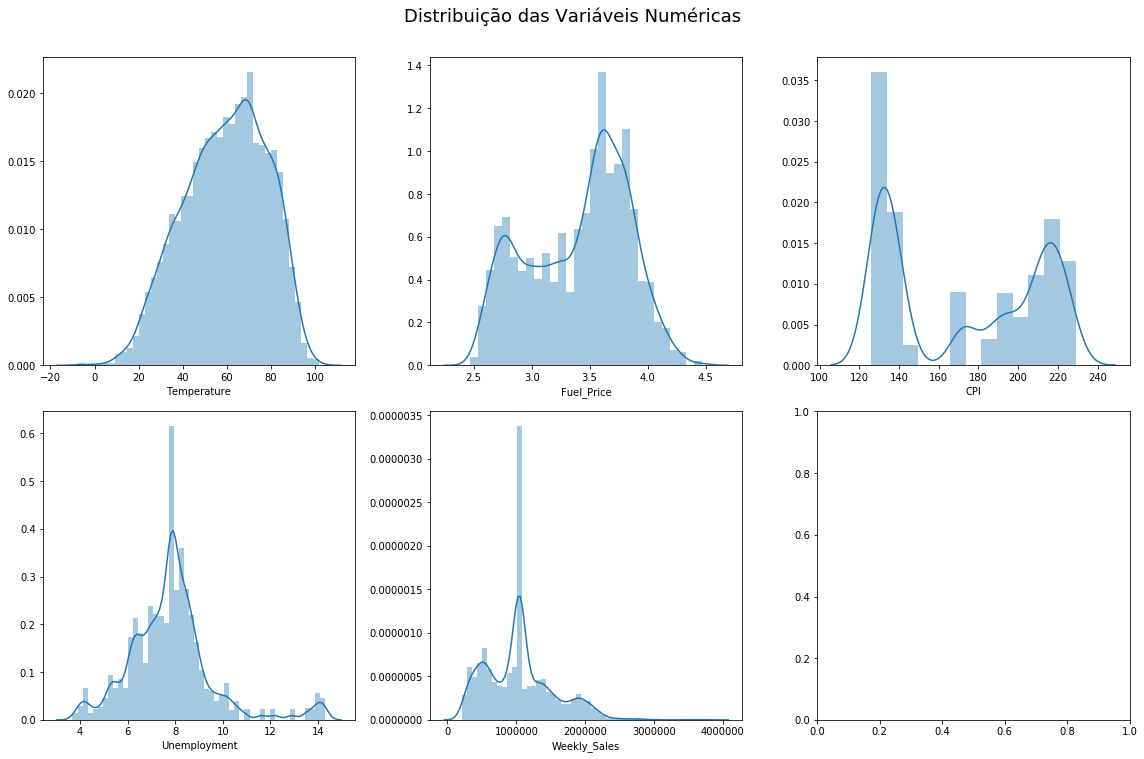

In [23]:
plot_num('Distribuição das Variáveis Numéricas', df_num)

- E possível observar que a variável **Temperature** segue uma distribuição normal, porém há um skewness negativo, sendo possível analisar uma cauda maior para o lado esquerdo.
- Ao observa as variáveis **Unemployment** e **Weekly_Sales**, é possível exengar uma semelhança com a distribuição normal, porém com tendo um coeficiente de assimetria positivo e uma curtose alta.
- O restante das variáveis não parecem estar próxima de uma distribuição normal.

## Distribuição das variáveis numéricas aplicando log

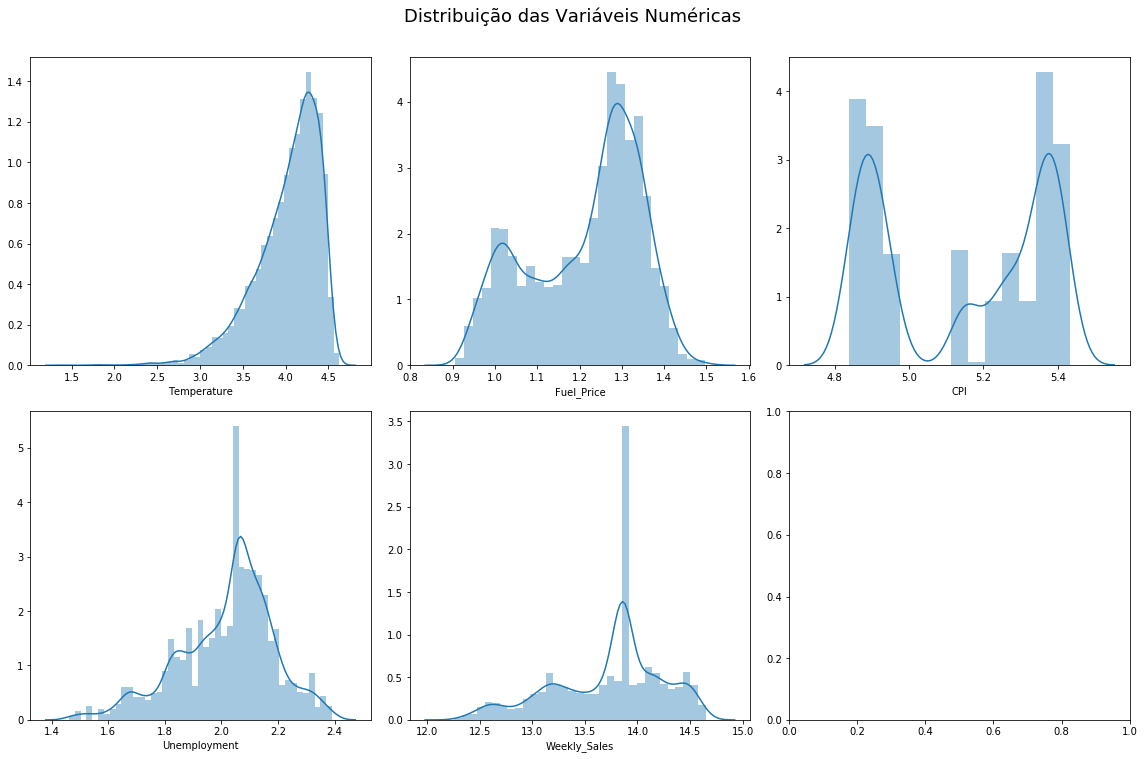

In [24]:
plot_num('Distribuição das Variáveis Numéricas', np.log(df_outliers))

Análise...

## Weekly_Sales (Target)

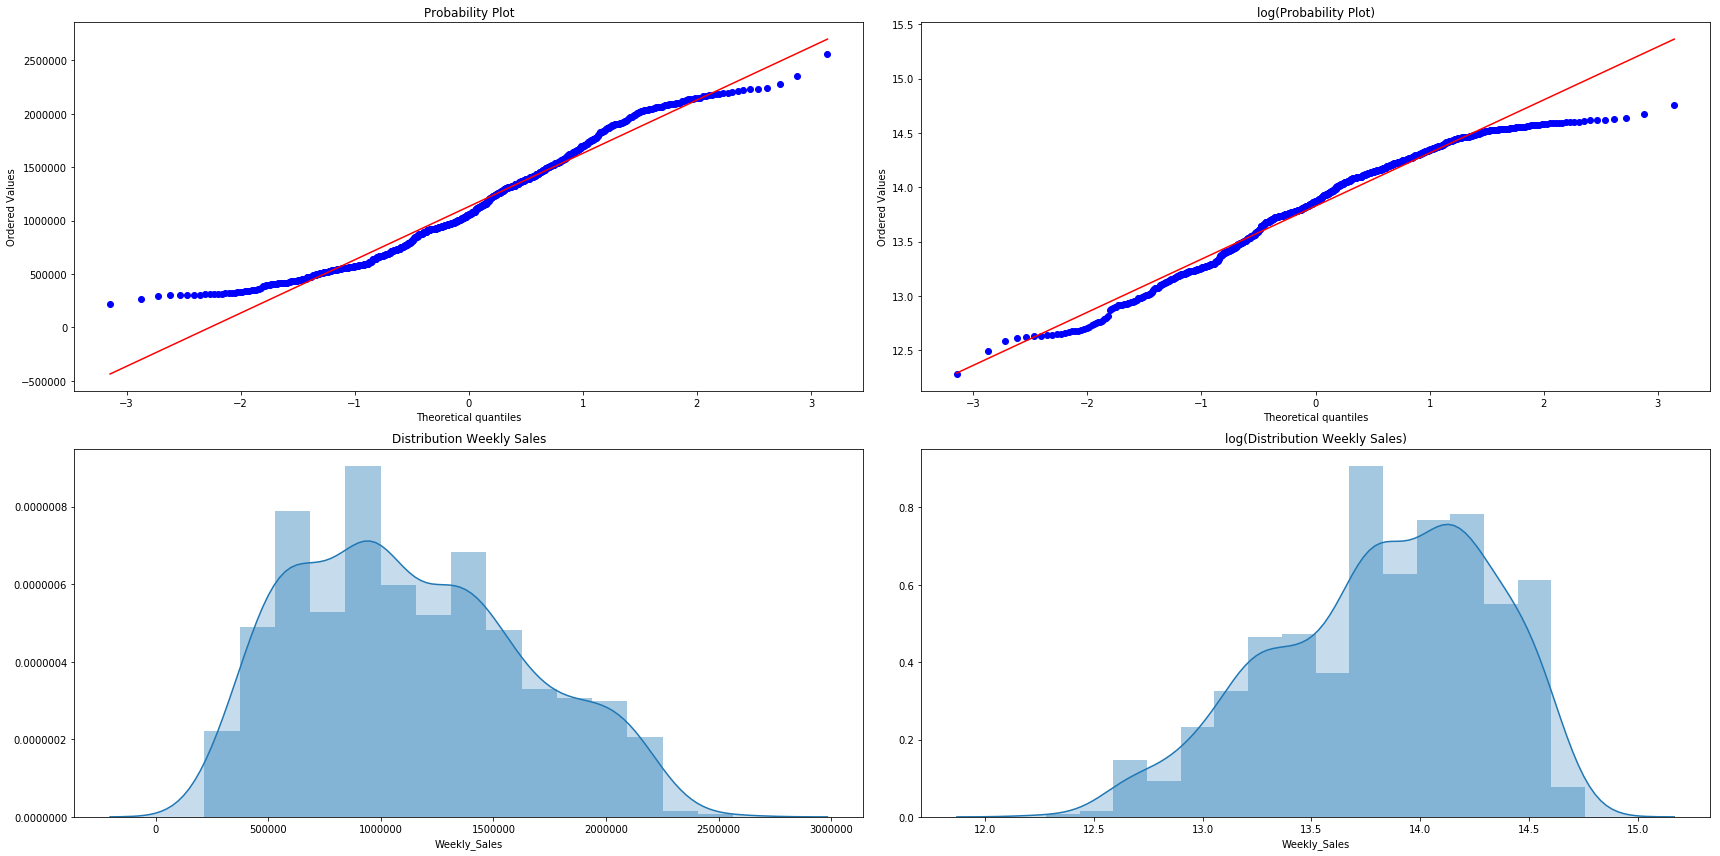

In [105]:
plt.figure(figsize=(24, 12))

plt.subplot(221)
# sns.lineplot(x='Date', y='Weekly_Sales', data=df)
probplot(df['Weekly_Sales'], plot=plt)

plt.subplot(222)
probplot(np.log(df['Weekly_Sales']), plot=plt)
plt.title('log(Probability Plot)')

plt.subplot(223)
sns.distplot(df['Weekly_Sales'], hist=True, kde_kws={'shade': True})
plt.title('Distribution Weekly Sales')

plt.subplot(224)
sns.distplot(np.log(df['Weekly_Sales']), hist=True, kde_kws={'shade': True})
plt.title('log(Distribution Weekly Sales)')


plt.tight_layout()

plt.show()

Analisando os gráfico é possível observar que a reta regressão não ajusta-se tão bem aos dados. Na parte inferior e também na parte superior os dados estão se distanciando da reta de regressão, gerando assim um maior erro para o modelo.

In [106]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,833.00,19.99,12.24,1.00,9.00,19.00,29.00,45.00
Temperature,833.00,63.21,16.56,7.46,52.21,65.95,75.81,95.91
Fuel_Price,833.00,3.68,0.25,3.04,3.51,3.69,3.87,4.30
MarkDown1,833.00,6488.51,3973.08,99.40,3453.42,5965.99,8679.19,20397.03
MarkDown2,833.00,670.53,1297.91,-265.76,30.70,126.67,475.99,6005.06
MarkDown3,833.00,39.39,56.85,-1.00,3.03,13.42,50.93,289.74
MarkDown4,833.00,2128.83,1982.23,0.46,590.68,1580.98,3068.98,9211.05
MarkDown5,833.00,3859.57,2345.91,180.07,2057.71,3376.66,5230.46,11870.68
CPI,833.00,177.37,39.73,129.82,137.92,191.17,221.00,227.04
Unemployment,833.00,7.17,1.49,4.08,6.17,7.14,8.19,10.93


# Transformações

## IsHoliday

#### Transformando a variável IsHoliday de False e True para 0 e 1.

In [107]:
df['IsHoliday'] = df['IsHoliday'].apply(lambda x: 1 if x else 0)

In [108]:
df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales
1,1,2011-11-18,62.25,3.31,6074.12,254.39,51.98,427.39,5988.57,218.22,7.87,0,1539483.70
10,1,2012-01-20,54.11,3.27,4139.87,2807.19,33.88,500.62,3400.21,219.99,7.35,0,1394393.84
11,1,2012-01-27,54.26,3.29,1164.46,1082.74,44.00,11.00,1222.19,220.08,7.35,0,1319325.59
17,1,2012-09-03,58.76,3.67,10331.04,151.88,6.00,671.43,5509.84,221.06,7.35,0,1675431.16
18,1,2012-03-16,64.74,3.73,4298.16,7.50,2.02,2724.65,2017.69,221.21,7.35,0,1677472.78


## Store

#### Removendo o ID da loja

In [109]:
df.drop(['Store'], axis=1, inplace=True)

In [110]:
df.head()

,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales
1,2011-11-18,62.25,3.31,6074.12,254.39,51.98,427.39,5988.57,218.22,7.87,0,1539483.70
10,2012-01-20,54.11,3.27,4139.87,2807.19,33.88,500.62,3400.21,219.99,7.35,0,1394393.84
11,2012-01-27,54.26,3.29,1164.46,1082.74,44.00,11.00,1222.19,220.08,7.35,0,1319325.59
17,2012-09-03,58.76,3.67,10331.04,151.88,6.00,671.43,5509.84,221.06,7.35,0,1675431.16
18,2012-03-16,64.74,3.73,4298.16,7.50,2.02,2724.65,2017.69,221.21,7.35,0,1677472.78


## Date

In [111]:
df = df.drop(['Date'], axis=1)

# Modelagem

## Correlação

In [112]:
df.corr()

,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales
Temperature,1.00,0.00,0.15,-0.47,-0.10,0.28,0.14,0.20,-0.01,0.06,0.19
Fuel_Price,0.00,1.00,0.18,-0.07,-0.15,-0.04,-0.07,-0.39,0.23,0.04,0.09
MarkDown1,0.15,0.18,1.00,-0.07,0.13,0.53,0.32,-0.07,0.05,0.16,0.37
MarkDown2,-0.47,-0.07,-0.07,1.00,0.02,-0.07,-0.01,-0.02,0.01,0.02,-0.04
MarkDown3,-0.10,-0.15,0.13,0.02,1.00,0.02,0.15,-0.01,0.03,0.04,0.21
MarkDown4,0.28,-0.04,0.53,-0.07,0.02,1.00,0.24,-0.06,0.01,0.12,0.31
MarkDown5,0.14,-0.07,0.32,-0.01,0.15,0.24,1.00,0.03,-0.04,0.00,0.47
CPI,0.20,-0.39,-0.07,-0.02,-0.01,-0.06,0.03,1.00,-0.26,0.02,-0.10
Unemployment,-0.01,0.23,0.05,0.01,0.03,0.01,-0.04,-0.26,1.00,0.01,-0.14
IsHoliday,0.06,0.04,0.16,0.02,0.04,0.12,0.00,0.02,0.01,1.00,-0.01


In [113]:
df.corr()['Weekly_Sales'].sort_values(ascending=False)

Weekly_Sales    1.00
MarkDown5       0.47
MarkDown1       0.37
MarkDown4       0.31
MarkDown3       0.21
Temperature     0.19
Fuel_Price      0.09
IsHoliday      -0.01
MarkDown2      -0.04
CPI            -0.10
Unemployment   -0.14
Name: Weekly_Sales, dtype: float64

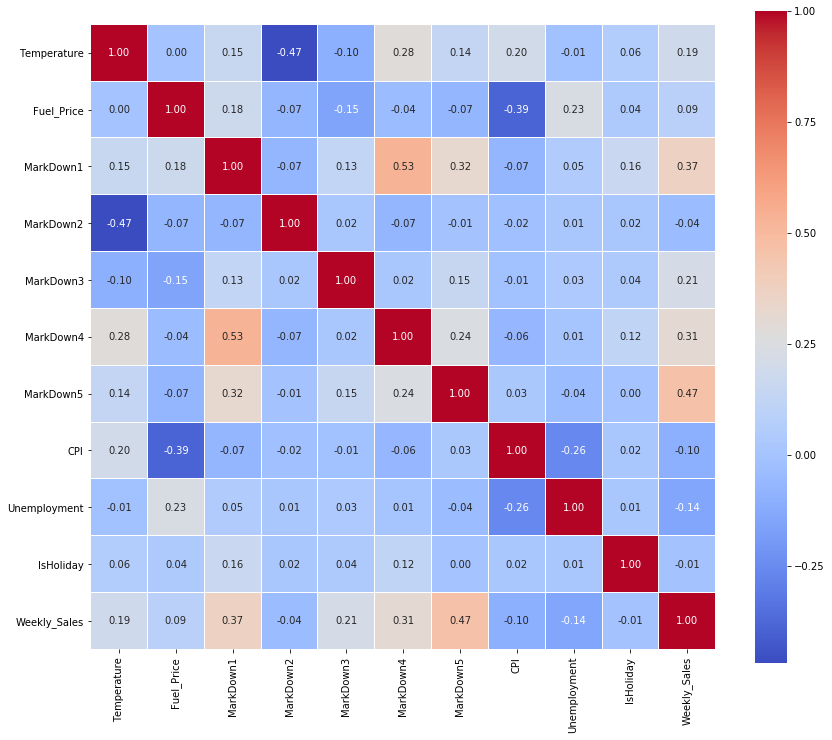

In [114]:
plt.figure(figsize=(14, 12))

sns.heatmap(df.corr(), linewidths=0.01, cmap='coolwarm', square=True, annot=True, fmt='.2f')

plt.show()

Ao analisar os resultados das correlações das variáveis preditoras com a variável resposta, observa-se um valor muito pequeno. Seguiremos adianta para a análise do modelo e observaremos o nível de importância dessas variável.

### Save dataframe cleaned

In [25]:
joblib.dump(df, '../backup/df_limpo.gz', compress=True)

['../backup/df_limpo.gz']

In [10]:
df = joblib.load('../backup/df_limpo.gz')

## Divisão dos dados

In [ ]:
df.head()

,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Weekly_Sales
0,42.31,2.57,211.10,8.11,0,1643690.90
1,38.51,2.55,211.24,8.11,1,1641957.44
2,39.93,2.51,211.29,8.11,0,1611968.17
3,46.63,2.56,211.32,8.11,0,1409727.59
4,46.50,2.62,211.35,8.11,0,1554806.68


In [23]:
X, y = df.drop(['Weekly_Sales'], axis=1), df['Weekly_Sales']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [25]:
X_train.shape, X_test.shape

((5279, 5), (2263, 5))

## Pipelines

In [ ]:
# ============================================================
# StandardScaler
# ============================================================

pip_1 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

pip_2 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', ElasticNet())
])

pip_3 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DecisionTreeRegressor())
])

pip_4 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR(kernel='linear'))
])

pip_5 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR(kernel='poly'))
])

pip_6 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR(kernel='rbf'))
])

# ============================================================
# MinMaxScaler
# ============================================================

pip_7 = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('model', LinearRegression())
])

pip_8 = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('model', ElasticNet())
])

pip_9 = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('model', DecisionTreeRegressor())
])

pip_10 = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('model', SVR(kernel='linear'))
])

pip_11 = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('model', SVR(kernel='poly'))
])

pip_12 = Pipeline([
    ('min_max_scaler', MinMaxScaler()),
    ('model', SVR(kernel='rbf'))
])

# ============================================================
# Normalizer
# ============================================================

pip_13 = Pipeline([
    ('normalizer', Normalizer()),
    ('model', LinearRegression())
])

pip_14 = Pipeline([
    ('normalizer', Normalizer()),
    ('model', ElasticNet())
])

pip_15 = Pipeline([
    ('normalizer', Normalizer()),
    ('model', DecisionTreeRegressor())
])

pip_16 = Pipeline([
    ('normalizer', Normalizer()),
    ('model', SVR(kernel='linear'))
])

pip_17 = Pipeline([
    ('normalizer', Normalizer()),
    ('model', SVR(kernel='poly'))
])

pip_18 = Pipeline([
    ('normalizer', Normalizer()),
    ('model', SVR(kernel='rbf'))
])

## Comparação de modelos

In [115]:
modelos = []

modelos.append(('Linear Regression', LinearRegression()))
modelos.append(('Decission Tree', DecisionTreeRegressor()))
modelos.append(('Random Forest', RandomForestRegressor()))
# modelos.append(('SVR Linear', SVR(kernel='linear')))
# modelos.append(('SVR Poly', SVR(kernel='poly')))
# modelos.append(('SVR Rbf', SVR(kernel='rbf')))

# modelos.append(('scaler_lr', pip_1))
# modelos.append(('scaler_en', pip_2))
# modelos.append(('scaler_dtr', pip_3))
# modelos.append(('scaler_svc_linear', pip_4))
# modelos.append(('scaler_svc_poly', pip_5))
# modelos.append(('scaler_svc_rbf', pip_6))

# modelos.append(('minmax_lr', pip_7))
# modelos.append(('minmax_en', pip_8))
# modelos.append(('minmax_dtr', pip_9))
# modelos.append(('minmax_svc_linear', pip_10))
# modelos.append(('minmax_svc_poly', pip_11))
# modelos.append(('minmax_svc_rbf', pip_12))

# modelos.append(('normalizer_lr', pip_13))
# modelos.append(('normalizer_en', pip_14))
# modelos.append(('normalizer_dtr', pip_15))
# modelos.append(('normalizer_svc_linear', pip_16))
# modelos.append(('normalizer_svc_poly', pip_17))
# modelos.append(('normalizer_svc_rbf', pip_18))

## Scandard Scaler

                   RMSE
Random Forest      0.79
Linear Regression  0.81
Decission Tree     1.10


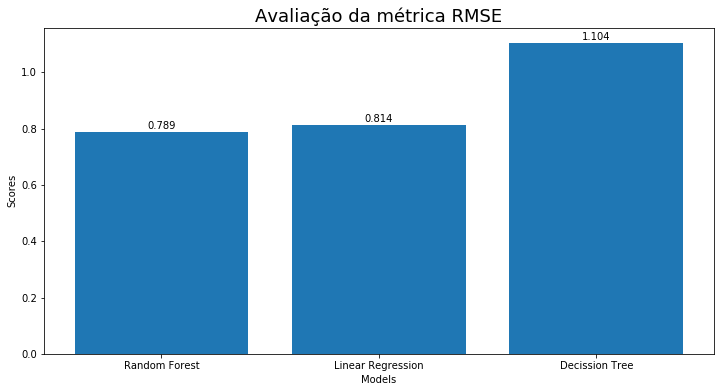

In [116]:
scaler = StandardScaler()

df_scaler = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

X, y = df_scaler.drop(['Weekly_Sales'], axis=1), df_scaler['Weekly_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

resultados = []

for nome, modelo in modelos:
    resultados.append(
        (nome, model_accuracy(modelo, X_train, y_train))
    )

plot_metrics(resultados, 'RMSE')

## MinMaxScaler

                   RMSE
Random Forest      0.17
Linear Regression  0.18
Decission Tree     0.24


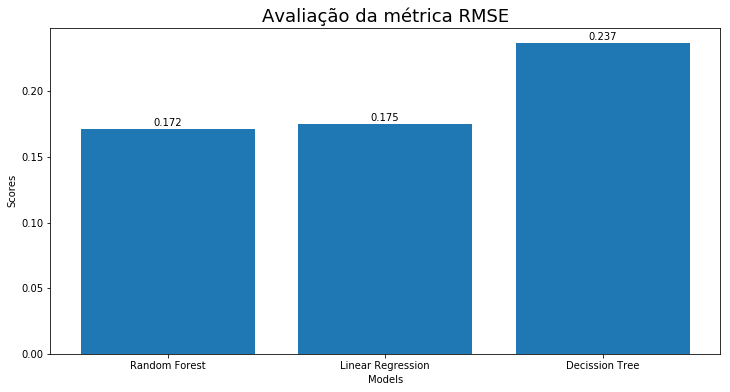

In [117]:
min_max_scaler = MinMaxScaler()

df_scaler = pd.DataFrame(min_max_scaler.fit_transform(df), columns=df.columns)

X, y = df_scaler.drop(['Weekly_Sales'], axis=1), df_scaler['Weekly_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

resultados = []

for nome, modelo in modelos:
    resultados.append(
        (nome, model_accuracy(modelo, X_train, y_train))
    )

plot_metrics(resultados, 'RMSE')

## Normalizer

                   RMSE
Linear Regression  0.00
Random Forest      0.00
Decission Tree     0.00


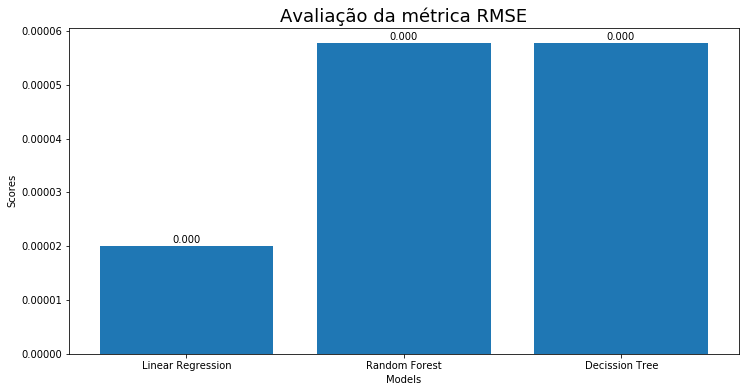

In [118]:
normalizer = Normalizer()

df_scaler = pd.DataFrame(normalizer.fit_transform(df), columns=df.columns)

X, y = df_scaler.drop(['Weekly_Sales'], axis=1), df_scaler['Weekly_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

resultados = []

for nome, modelo in modelos:
    resultados.append(
        (nome, model_accuracy(modelo, X_train, y_train))
    )

plot_metrics(resultados, 'RMSE')

## Z-Score

                   RMSE
Random Forest      0.23
Decission Tree     0.29
Linear Regression  0.35


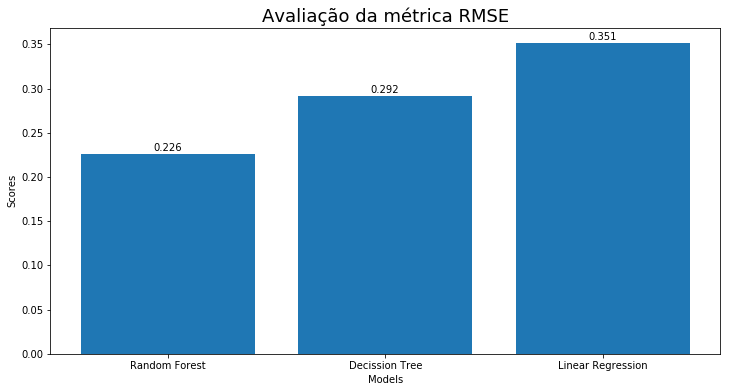

In [119]:
X, y = df_scaler.drop(['Weekly_Sales'], axis=1), zscore(df_scaler['Weekly_Sales'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

resultados = []

for nome, modelo in modelos:
    resultados.append(
        (nome, model_accuracy(modelo, X_train, y_train))
    )

plot_metrics(resultados, 'RMSE')

## Random Forest MinMaxScaler

In [120]:
min_max_scaler = MinMaxScaler()

df_scaler = pd.DataFrame(min_max_scaler.fit_transform(df), columns=df.columns)

X, y = df_scaler.drop(['Weekly_Sales'], axis=1), df_scaler['Weekly_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model_1 = RandomForestRegressor()
model_1.fit(X_train, y_train)

y_pred_1 = model_1.predict(X_test)

print(mean_squared_error(y_test, y_pred_1)**0.5)

0.1610711182772202


In [121]:
model_1.score(X_train, y_train), model_1.score(X_test, y_test)

(0.9053949836077991, 0.349041194981231)

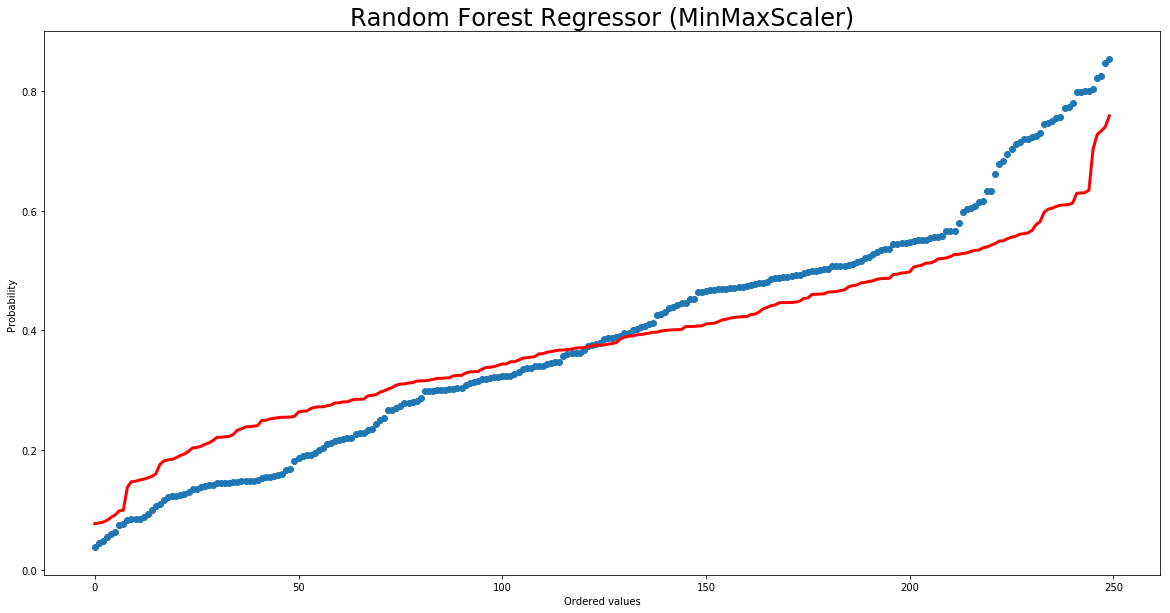

In [122]:
plt.figure(figsize=(20, 10))

plt.scatter(np.arange(y_test.shape[0]), np.sort(y_test))

plt.plot(np.sort(y_pred_1), linewidth=3, color='r')

plt.title('Random Forest Regressor (MinMaxScaler)', fontsize=24)

plt.xlabel('Ordered values')
plt.ylabel('Probability')

plt.show()

Overfitting

## LinearRegression with Normalizer

In [123]:
normalizer = Normalizer()

df_scaler = pd.DataFrame(normalizer.fit_transform(df), columns=df.columns)

X, y = df_scaler.drop(['Weekly_Sales'], axis=1), df_scaler['Weekly_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model_2 = LinearRegression()
model_2.fit(X_train, y_train)

y_pred_2 = model_2.predict(X_test)

print(mean_squared_error(y_test, y_pred_2)**0.5)

2.2581692217495874e-05


In [124]:
model_2.score(X_train, y_train), model_1.score(X_test, y_test)

(0.8962710338321676, -220647317.07874596)

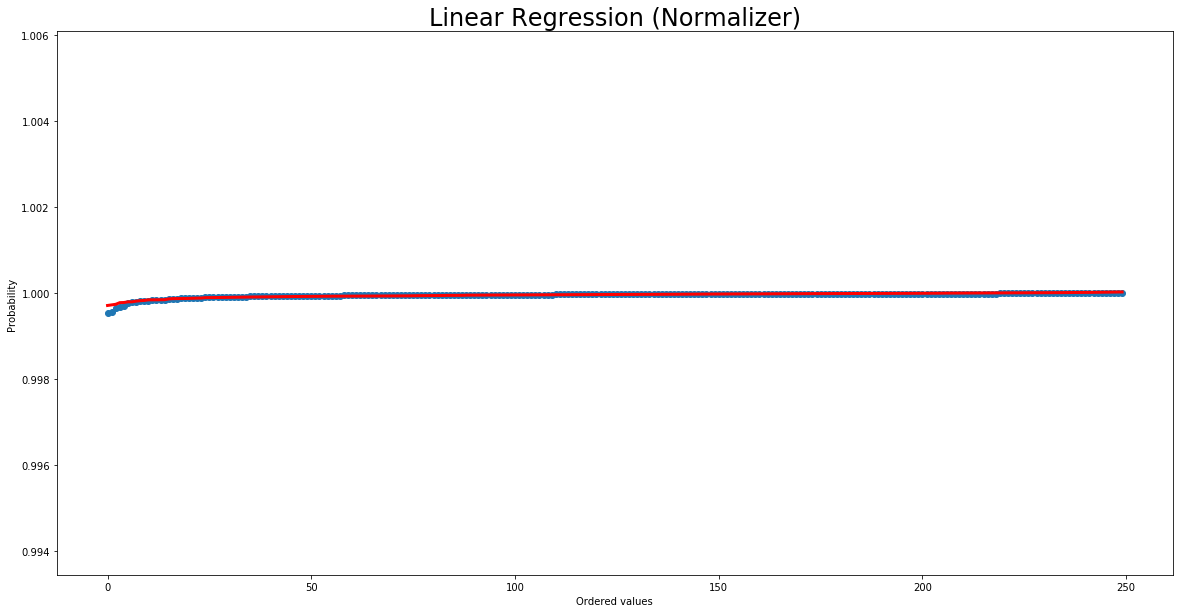

In [125]:
plt.figure(figsize=(20, 10))

plt.scatter(np.arange(y_test.shape[0]), np.sort(y_test))

plt.plot(np.sort(y_pred_2), linewidth=3, color='r')

plt.title('Linear Regression (Normalizer)', fontsize=24)

plt.xlabel('Ordered values')
plt.ylabel('Probability')

plt.show()

Overfitting

## RandomForest with target in Z-Score

In [164]:
X, y = df_scaler.drop(['Weekly_Sales'], axis=1), zscore(df_scaler['Weekly_Sales'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

model_3 = RandomForestRegressor(random_state=seed)
model_3.fit(X_train, y_train)

y_pred_3 = model_3.predict(X_test)

print(mean_squared_error(y_test, y_pred_3)**0.5)

0.24689301188103416


In [165]:
model_3.score(X_train, y_train), model_3.score(X_test, y_test)

(0.9904895435902505, 0.9365145773590471)

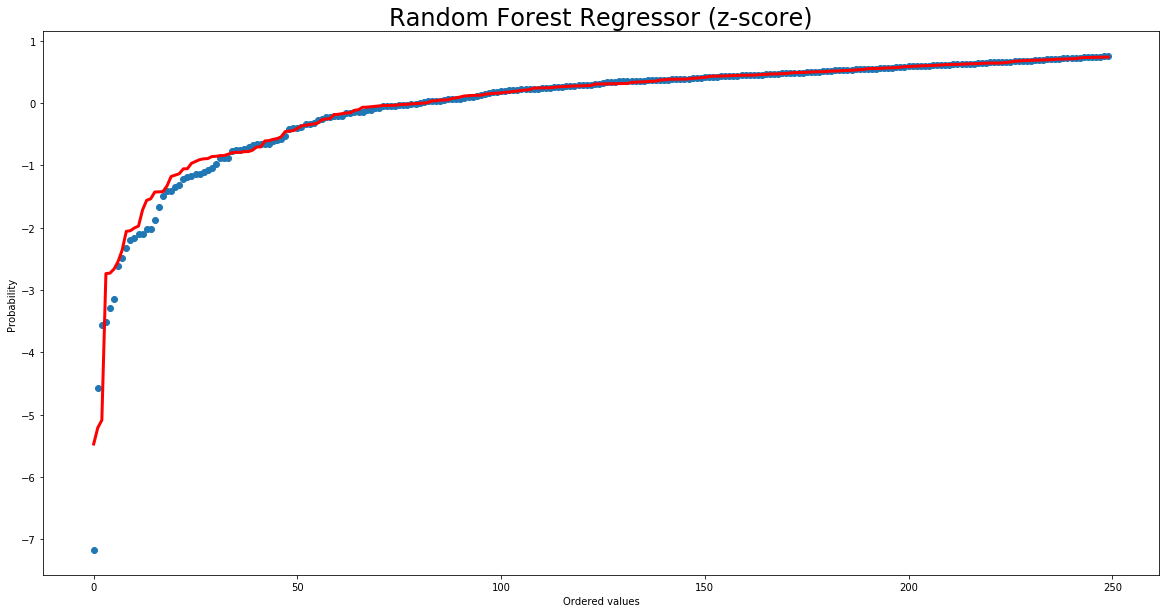

In [166]:
plt.figure(figsize=(20, 10))

plt.scatter(np.arange(y_test.shape[0]), np.sort(y_test))

plt.plot(np.sort(y_pred_3), linewidth=3, color='r')

plt.title('Random Forest Regressor (z-score)', fontsize=24)

plt.xlabel('Ordered values')
plt.ylabel('Probability')

plt.show()

Baseado no resultado dos scores, pode-se concluir que não overfiting nos dados. Por este motivo utilizaremos o modelo de RandomForest transformando a variável target com o z-score.

## GridSearchCV

In [169]:
params = {
    'n_estimators': np.arange(1, 101),
    'max_depth': np.arange(1, 11)
#     'min_samples_split': np.arange(2, 11),
#     'min_samples_leaf': np.arange(2, 11),
#     'min_weight_fraction_leaf': np.linspace(0, 0.5, 6),
#     'max_features': np.arange(1, 11),
#     'min_impurity_decrease': np.arange(1, 11, dtype=np.float)
}

In [170]:
model_4 = GridSearchCV(
    RandomForestRegressor(random_state=seed), 
    param_grid=params,
    cv=10
)

model_4.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=314, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': array([  1,   2, ...,  99, 100]), 'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [172]:
joblib.dump(model_4, '../backup/model_4.gz', compress=True)

['../backup/model_4.gz']

In [173]:
model_4.best_score_

0.9490701017658737

In [174]:
model_4.best_params_

{'max_depth': 9, 'n_estimators': 41}

In [176]:
y_pred_4 = model_4.predict(X_test)

In [177]:
model_4.score(X_train, y_train), model_4.score(X_test, y_test)

(0.993126575087691, 0.940945471100148)